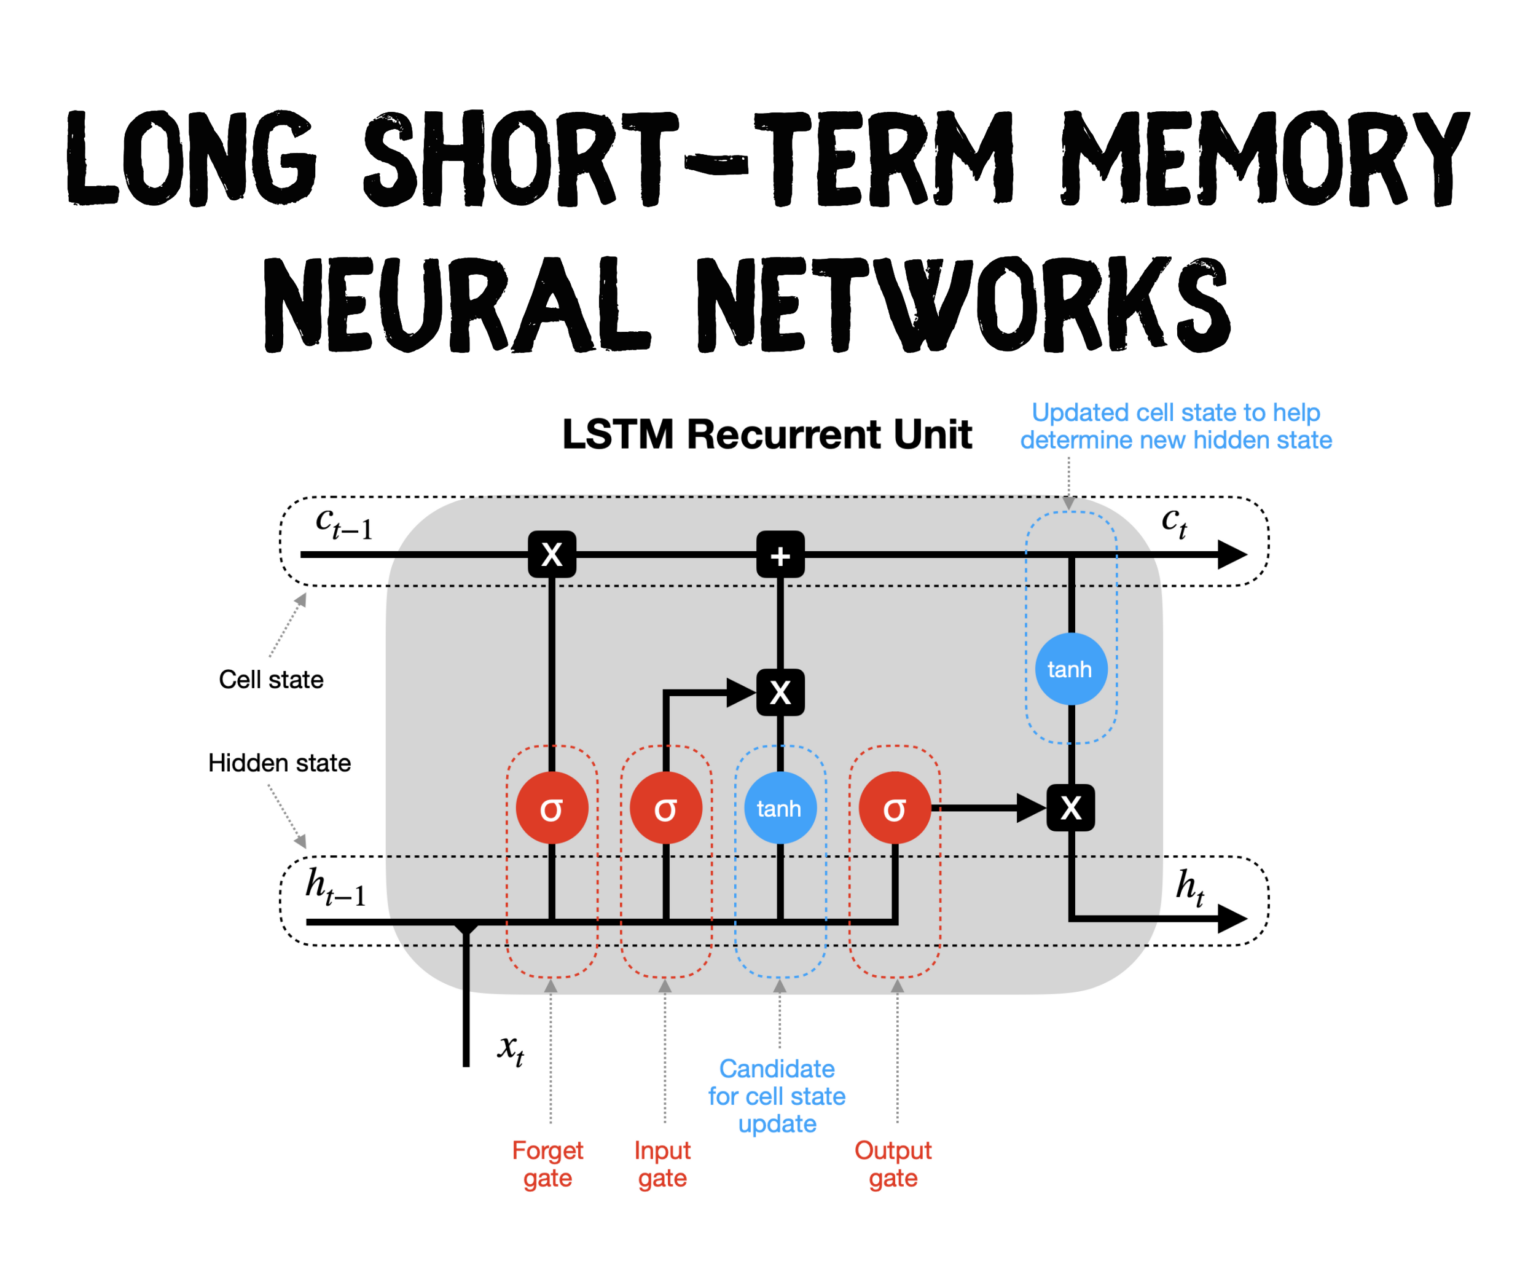![image.png]

In [1]:
import pandas as pd
import lstm
import matplotlib.pyplot as plt
import numpy as np

In [2]:

data = pd.read_csv("/home/aldo/maestria//tesis/vlf/PIURA/PIU_1min-AMP-SXR-State012_2024-12-17--2025-08-24.csv", index_col=[0],parse_dates=[0])

In [14]:
data["state_single"] = (data["state"]!=0 ) /1

In [3]:
data["NAA-filtlog"] = 20*np.log10(data["NAA-filt"]+0.0001)

In [4]:
%matplotlib widget

In [ ]:
fig, ax = plt.subplots()
ax2 = ax.twinx()

ax.plot(data["NAA-filtlog"], color="blue", lw=1)
ax.set_ylim(-10,15)
ax2.plot(data["state"], color="coral", lw=1, alpha=0.8)


In [15]:
   
sequences, sequence_labels = lstm.prepare_dataseqs(data, signal_column="NAA-filtlog", 
                                              label_column="state_single", sequence_length=30)
    
# s= (n_sequences, 30, 2)
print(f"Labels shape: {sequence_labels.shape}")

# Calculate class weights
class_weights = lstm.calculate_class_weights(sequence_labels)

Labels shape: (317077,)
Class distribution: Counter({np.float64(0.0): 309089, np.float64(1.0): 7988})
Using class weights: {0: 1.0, 1: 60.0, 2: 25.0}


In [6]:
print("Class weights", class_weights)

Class weights {0: 1.0, 1: 60.0, 2: 25.0}


In [19]:
n_sequences = len(sequences)
train_end = int(0.7 * n_sequences)
val_end = int(0.85 * n_sequences)

X_train = sequences[:train_end]
y_train = sequence_labels[:train_end]
X_val   = sequences[train_end:val_end]
y_val   = sequence_labels[train_end:val_end]
X_test  = sequences[val_end:]
y_test  = sequence_labels[val_end:]

print(f"\nData Split:")
print(f"training: {len(X_train)}")
print(f"validation: {len(X_val)}")
print(f"test : {len(X_test)}")


Data Split:
training: 221953
validation: 47562
test : 47562


In [20]:
train_dataset = lstm.TensorDataset(lstm.torch.FloatTensor(X_train), lstm.torch.LongTensor(y_train))
val_dataset = lstm.TensorDataset(lstm.torch.FloatTensor(X_val), lstm.torch.LongTensor(y_val))
test_dataset = lstm.TensorDataset(lstm.torch.FloatTensor(X_test), lstm.torch.LongTensor(y_test))

train_loader = lstm.DataLoader(train_dataset, batch_size=64, shuffle=False)
val_loader = lstm.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = lstm.DataLoader(test_dataset, batch_size=64, shuffle=False)


model = lstm.VLFEventDetector(input_dim=2, hidden_dim=64, num_layers=2, num_classes=3, dropout=0.3)
print(f"\nModel parameters: {sum(p.numel() for p in model.parameters()):,}")

# train
print("\nStarting training...")
model, train_losses, val_losses = lstm.train_model(
    model, train_loader, val_loader, class_weights, num_epochs=100, patience=15
)


print("\nEvaluating model on test set...")
predictions, true_labels, probabilities = lstm.evaluate_model(model, test_loader, class_names=["normal", "flare"])


Model parameters: 72,868

Starting training...
Using device: cuda
Epoch [10/100], Train Loss: nan, Val Loss: nan
Early stopping at epoch 15

Evaluating model on test set...

CLASSIFICATION REPORT
              precision    recall  f1-score   support

      normal       0.97      1.00      0.98     46021
       flare       0.00      0.00      0.00      1541

    accuracy                           0.97     47562
   macro avg       0.48      0.50      0.49     47562
weighted avg       0.94      0.97      0.95     47562

CONFUSION MATRIX:
[[46021     0]
 [ 1541     0]]

F1 SCORES:
normal: 0.9835
flare: 0.0000


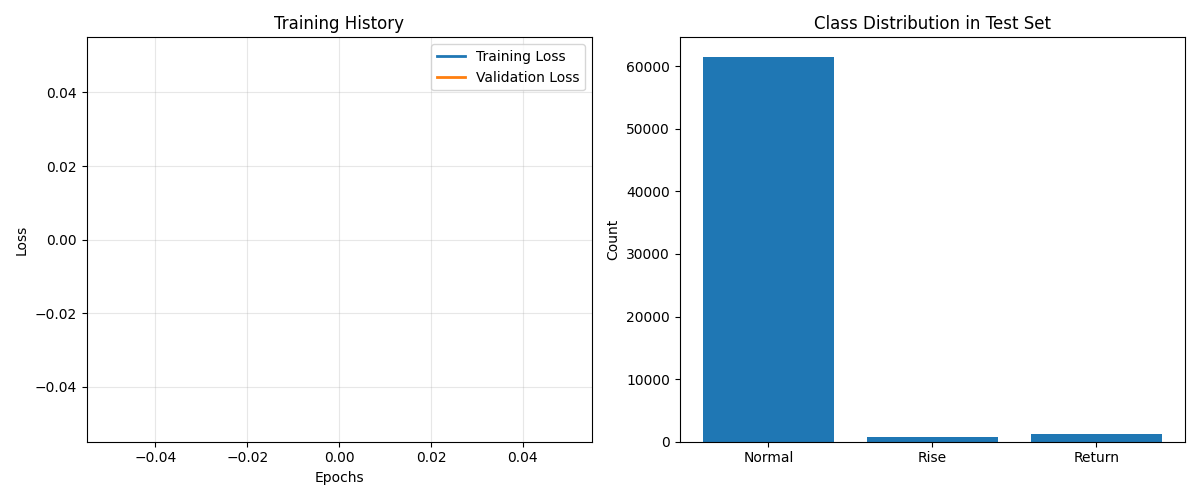

In [13]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot class distribution
plt.subplot(1, 2, 2)
class_counts = lstm.Counter(true_labels)
plt.bar(['Normal', 'Rise', 'Return'], [class_counts[0], class_counts[1], class_counts[2]])
plt.title('Class Distribution in Test Set')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


# torch.save({
#    'model_state_dict': model.state_dict(),
#    'class_weights': class_weights,
#    'train_losses': train_losses,
#    'val_losses': val_losses
# }, 'vlf_event_detector_data.pth')

In [ ]:
if __name__ == "__main__":
    # Load your DataFrame (replace this with your actual data loading)
    # data = pd.read_csv('your_data.csv', index_col='time', parse_dates=True)
    
    # For demonstration, create a sample DataFrame structure
    print("Creating sample DataFrame structure...")
    dates = pd.date_range(start='2024-01-01', periods=300000, freq='1min')
    data = pd.DataFrame({
        'NPM-filt': np.random.randn(300000),
        'NAA-filt': np.random.randn(300000),
        'state': np.random.choice([0, 1, 2], size=300000, p=[0.97, 0.02, 0.01]),
        'GOES-18_long': np.random.rand(300000) * 0.00001
    }, index=dates)
    
    print("DataFrame sample:")
    print(data.head())
    
    # Run main training
    model, predictions, true_labels, probabilities = main_from_dataframe(
        data, signal_column='NAA-filt', label_column='state'
    )
    
    # Uncomment to test different weight combinations
    # weight_combinations = [
    #     {0: 1.0, 1: 40.0, 2: 20.0},  # Conservative
    #     {0: 1.0, 1: 60.0, 2: 25.0},  # Balanced
    #     {0: 1.0, 1: 80.0, 2: 30.0},  # Aggressive
    #     {0: 1.0, 1: 100.0, 2: 35.0}  # Very aggressive
    # ]
    # best_model, best_weights = test_weight_combinations(data, weight_combinations)